# Models V: Categorical Predictors (2-levels)

So far we've been using `ols` to perform *univariate* and *multiple* regression with *continuous* predictor variables. But often you'll also be working with **categorical** predictor variables. In this notebook we'll discuss how to build models using:
- a categorical variable with 2 levels 
- a categorical variable with 2 levels + a continuous variable
- a categorical variable with 2 levels, a continuous variable, and an interaction term

## Slides for reference

[Modeling Data V (slides)](https://stat-intuitions.com/lectures/wk5/1.html)  

## Data

Let's return to the credit card dataset we used in Notebook `02_models`

This is a *smaller* version of that dataset with observations from 76 different people with the following columns:

| Variable   | Description                     |
|------------|---------------------------------|
| Income     | in thousand dollars            |
| Limit      | credit limit                    |
| Rating     | credit rating                   |
| Cards      | number of credit cards          |
| Age        | in years                        |
| Education  | years of education              |
| Gender     | male or female                  |
| Student    | student or not                  |
| Married    | married or not                  |
| Ethnicity  | African American, Asian, Caucasian |
| Balance    | average credit card debt        |


In [2]:
import numpy as np
import polars as pl
from polars import col
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

# Load data
df = pl.read_csv('./data/credit-mini.csv')
df

Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance
f64,i64,i64,i64,i64,i64,str,str,str,str,i64
20.918,1233,128,3,47,18,"""Female""","""Yes""","""Yes""","""Asian""",16
10.842,4391,358,5,37,10,"""Female""","""Yes""","""Yes""","""Caucasian""",1216
29.705,3351,262,5,71,14,"""Female""","""No""","""Yes""","""Asian""",148
76.348,4697,344,4,60,18,"""Male""","""No""","""No""","""Asian""",108
30.622,3293,251,1,68,16,"""Male""","""Yes""","""No""","""Caucasian""",532
…,…,…,…,…,…,…,…,…,…,…
107.841,10384,728,3,87,7,"""Male""","""No""","""No""","""African American""",1597
27.47,2820,219,1,32,11,"""Female""","""No""","""Yes""","""Asian""",0
15.741,4788,360,1,39,14,"""Male""","""No""","""Yes""","""Asian""",689


## Categorical Predictor w/ 2 levels

Let's use `ols` to explore the example discussed in class in more detail: **do students have a different balance than non-students?**  

We'll fit 2 models:
- a *compact* model that only includes the intercept
- an *augmented* model that includes a **categorical predictor** for `Student` which has **2 levels** (`Yes` and `No`)

We can tell `ols` to treat a variable as **categorical** by wrapping it in `C()`

Then we'll test whether it's *worth it* to add `Student` as a predictor to the model by comparing them like we have before:

In [3]:
# Compact Model
c_model = ols('Balance ~ 1', data=df.to_pandas())
c_results = c_model.fit()

# Augmented Model
# Treat "Student" as a categorical variable
a_model = ols('Balance ~ C(Student)', data=df.to_pandas())
a_results = a_model.fit()

# Compare models - worth it?
anova_lm(c_results, a_results)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,75.0,2.028075e+07,0.0,NaN,NaN,NaN
1,74.0,1.721872e+07,1.0,3.062040e+06,13.159573,0.000523


It's worth it!  

Let's inspect our augmented model's **design matrix** to try to understand how `ols` is representing our **categorical variable** `Student`

In [4]:
# First 6 rows
a_model.exog[:5, :]

array([[1., 1.],
       [1., 1.],
       [1., 0.],
       [1., 0.],
       [1., 1.]])

If we look at our DataFrame, we can see that by default `C()` has converted: `No = 0` and `Yes = 1`

In [5]:
df.select('Balance', 'Student').head()

Balance,Student
i64,str
16,"""Yes"""
1216,"""Yes"""
148,"""No"""
108,"""No"""
532,"""Yes"""


Sometimes it's helpful to see the *entire* design matrix, especially as we move onto categorical variables with more than 2 levels in future notebooks. 

We've provided a helper function you can use that takes a model as input. You can see each observation plotted alongside how we've *encoded* `Student` in the design matrix (beige = 1; black = 0):

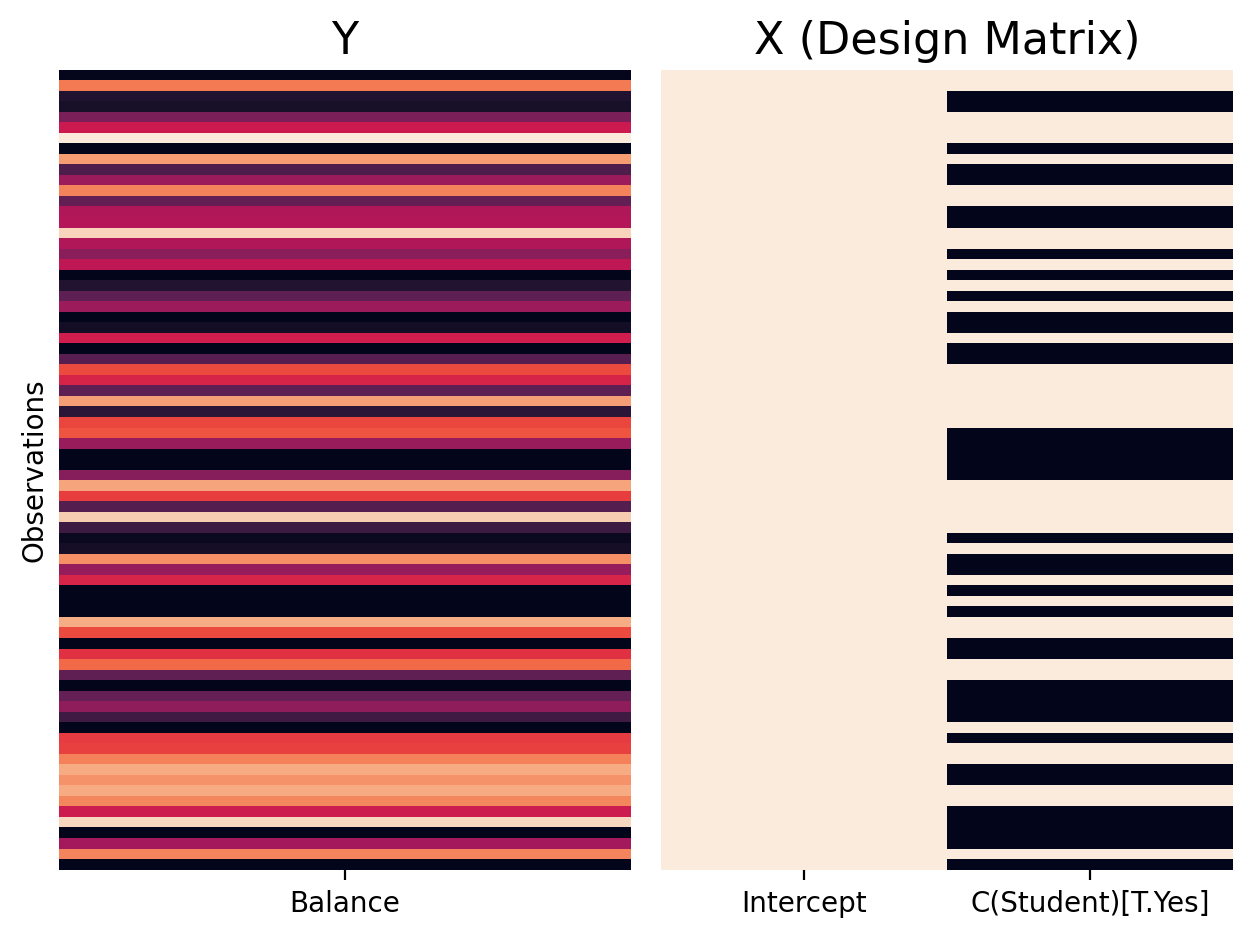

In [6]:
from helpers import plot_design_matrix

plot_design_matrix(a_model)

Let's inspect the `.summary()` to look at the *parameter estimates* for the model `Intercept` and `C(Student)[T.Yes]`

What do the *intercept* $\hat{\beta}_0$ and *slope* $\hat{\beta}_1$ here represent?  

To answer this question we need to understand what it means to think about *levels* of a category in terms of the *slopes* of lines that we can estimate. And how the 0s and 1s in the design matrix relate to this...

In [7]:
# slim=True just removes some extra information we don't currently need to save space
print(a_results.summary(slim=True)) 

                            OLS Regression Results                            
Dep. Variable:                Balance   R-squared:                       0.151
Model:                            OLS   Adj. R-squared:                  0.140
No. Observations:                  76   F-statistic:                     13.16
Covariance Type:            nonrobust   Prob (F-statistic):           0.000523
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           463.2368     78.252      5.920      0.000     307.317     619.156
C(Student)[T.Yes]   401.4474    110.664      3.628      0.001     180.944     621.951

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.


## Introduction to Categorical Coding Schemes

Let's think about about what it means to calculate a *slope* between 2 levels of a categorical variable.  

We typically define the slope as the "*change in y for 1-unit change in x*" - this makes sense when both variables are continuous - e.g. how much a person's `Balance` (y) increases for every additional year they're alive `Age` (x).

But what is a "unit change in x" if x is a **categorical variable** like `Student`?  

Its the *difference* between going from the mean of *first* level `No` to the mean of the *second* level `Yes`!

**The mean difference *is* the regression slope $\hat{\beta_1}$**

### Treatment (Dummy) Coding

While there are actually many ways to *encode* a categorical variable as columns of our **design matrix**, this intuitive idea is the default in both Python and R and is called **treatment (dummy) coding**.  

It uses the intercept to estimate the *mean* of one of the levels of your categorical variable as a **reference** level, and encodes the other levels as *mean differences* from that reference level.  

In the case of a variable with just 2 levels - this is just the mean difference between both levels, i.e. between `Student=No` and `Student=Yes`

In [8]:
# Get mean balance for each level separately
student_yes = df.filter(col('Student')=='Yes').select('Balance').mean()[0,0]
student_no = df.filter(col('Student')=='No').select('Balance').mean()[0,0]

print(f'Student: Yes = {student_yes:.3f}, No = {student_no:.3f}')
print(f"Mean Difference (Yes - No) = {student_yes - student_no:.5f}")

Student: Yes = 864.684, No = 463.237
Mean Difference (Yes - No) = 401.44737


In [9]:
# beta 0 = mean of No
# beta 1 = mean difference
a_results.params

Intercept            463.236842
C(Student)[T.Yes]    401.447368
dtype: float64

To make this more concrete, let's add a new column to our DataFrame called `Student_Dummy` that represents `Student` just like our **design matrix** does:

### Challenge
Use `when` and `lit` that we've imported for you below to create a new column in `df` called `Student_Dummy` that encodes `Yes = 1` and `No = 0` for the `Student` variable.

*Hint: You can use `.alias()` at the end of your `when` statement to give your new column a name.*

In [ ]:
from polars import when, lit

# Solution
df = df.with_columns(
    when(col('Student') == 'Yes')
    .then(lit(1))
    .otherwise(lit(0))
    .alias('Student_Dummy')
)

df.head()

Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance,Student_Dummy
f64,i64,i64,i64,i64,i64,str,str,str,str,i64,i32
20.918,1233,128,3,47,18,"""Female""","""Yes""","""Yes""","""Asian""",16,1
10.842,4391,358,5,37,10,"""Female""","""Yes""","""Yes""","""Caucasian""",1216,1
29.705,3351,262,5,71,14,"""Female""","""No""","""Yes""","""Asian""",148,0
76.348,4697,344,4,60,18,"""Male""","""No""","""No""","""Asian""",108,0
30.622,3293,251,1,68,16,"""Male""","""Yes""","""No""","""Caucasian""",532,1


Let's use the new column you made to create a figure and build our intuitions visually.  
First, we'll use `sns.barplot` to show the mean `Balance` of each level of `Student`  
Then, we'll ask `sns.regplot` to estimate and plot a regression line between our `Student_Dummy` and `Balance` variables; seaborn uses `ols` behind-the-scenes to do this!

You'll see below that the **slope** of `sns.regplot` going from `0` to `1` **is the same as the difference between bars**

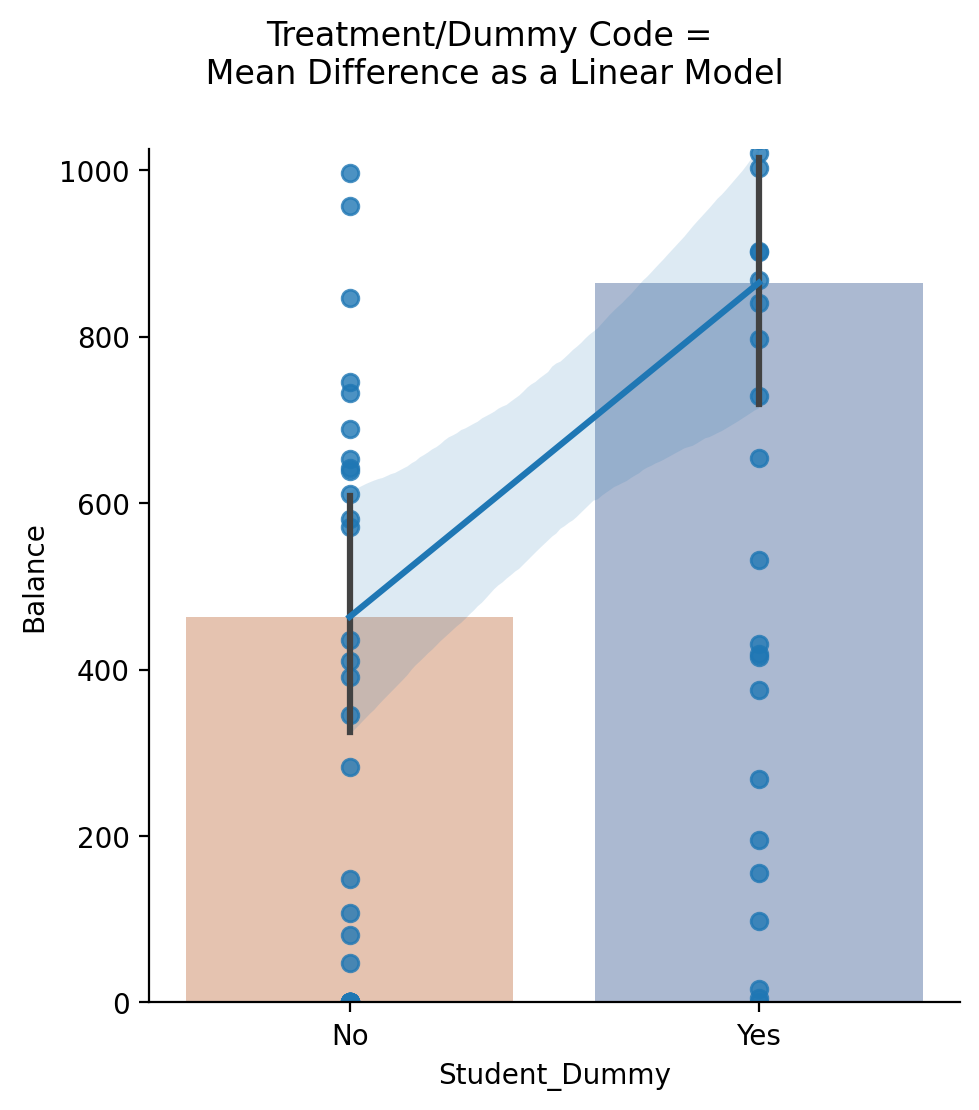

In [12]:
x_order = ['No', 'Yes']

# Create grid
grid = sns.FacetGrid(data=df.to_pandas(),height=5) ;

# Add a barpplot; we use map_dataframe so we can control hue separately for this layer
grid.map_dataframe(sns.barplot, 'Student', 'Balance', hue='Student',palette='deep', order=x_order, alpha=.5);

# Add a regression using our new column
grid.map_dataframe(sns.regplot, 'Student_Dummy', 'Balance')

# Aesthetics
grid.set(ylim=(0,1025));
grid.figure.suptitle("Treatment/Dummy Code =\n Mean Difference as a Linear Model", y=1.1);

We can also see this by estimating a new model using our newly created column `Student_Dummy` as a predictor and comparing its output to our original *augmented model*:

In [13]:
dummy_model = ols('Balance ~ Student_Dummy', data=df.to_pandas())
dummy_results = dummy_model.fit()

dummy_results.params

Intercept        463.236842
Student_Dummy    401.447368
dtype: float64

In [14]:
a_results.params

Intercept            463.236842
C(Student)[T.Yes]    401.447368
dtype: float64

### Interpreting parameter estimates

In our model our parameters represent:

- $\hat{\beta_0} = StudentNo_{mean}$ (reference level)
- $\hat{\beta_1} = StudentYes_{mean} - StudentNo_{mean}$

By default `ols` will use **alphabetically sort** the levels of your categorical predictor and use the **first one** as the reference level. In our case this is `No` as as `N` comes before `Y` alphabetically.

But we can be more explicit and even control what group is the reference category. Let's switch it to `Student = Yes`

We can do this by passing a second argument to `C()` in addition to our column name. We can use `Treatment(reference='category_level')` to tell `ols` that the reference category is `Yes`

In [15]:
# Set the reference group (intercept) to 'Yes'
ref_yes = ols("Balance ~ C(Student, Treatment(reference='Yes'))", data=df.to_pandas())

print(ref_yes.fit().summary(slim=True)) 

                            OLS Regression Results                            
Dep. Variable:                Balance   R-squared:                       0.151
Model:                            OLS   Adj. R-squared:                  0.140
No. Observations:                  76   F-statistic:                     13.16
Covariance Type:            nonrobust   Prob (F-statistic):           0.000523
                                                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
Intercept                                      864.6842     78.252     11.050      0.000     708.765    1020.604
C(Student, Treatment(reference='Yes'))[T.No]  -401.4474    110.664     -3.628      0.001    -621.951    -180.944

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.


Now the intercept is the mean of `Student = Yes` and the slope is `No - Yes`


In [16]:
student_yes

864.6842105263158

In [17]:
student_no - student_yes

-401.44736842105266

Inspecting the design matrix we can see that the coding has simply been flipped from our *augmented model* above:

In [18]:
# No = 1
# Yes = 0
ref_yes.exog[:5, :]

array([[1., 0.],
       [1., 0.],
       [1., 1.],
       [1., 1.],
       [1., 0.]])

In [19]:
# Originally we had
# No = 0
# Yes = 1
a_model.exog[:5, :]

array([[1., 1.],
       [1., 1.],
       [1., 0.],
       [1., 0.],
       [1., 1.]])

And just to confirm, we can see that the t-statistic and p-value that `ols` gives us is that same as running an independent t-test using `scipy`:


In [20]:
from scipy.stats import ttest_ind

results = ttest_ind(
    df.filter(col('Student') == 'No').select('Balance').to_numpy(),
    df.filter(col('Student') == 'Yes').select('Balance').to_numpy())

print(f"Independent samples t-test t({results.df[0]}) = {results.statistic[0]:.3f}, p = {results.pvalue[0]:.5f}")

Independent samples t-test t(74.0) = -3.628, p = 0.00052


Or in APA style:

In [21]:
print(f"Independent samples t-test t({results.df[0]}) = {results.statistic[0]:.3f}, p < .001")


Independent samples t-test t(74.0) = -3.628, p < .001


## Categorical (2-level) and Continuous Predictors

In the previous notebook `02_models` we saw that `Income` was also a meaningful predictor of `Balance`:


In [ ]:
grid = sns.lmplot(data=df, x='Income', y='Balance')

Let's expand our model to account for this relationship when looking at the difference between Students and non-Students.  

Specifically let's estimate a *multiple regression* that asks: **do students have difference Balances than non-students when accounting for Income?**

$$
\hat{Balance}_{i}= \beta_0 + \beta_1 Student + \beta_2 Income
$$

We'll also estimate another *univariate* regression that only looks at the relationship between Balance and Income:

$$
\hat{Balance}_{i}= \beta_0 + \beta_1 Income
$$

### Challenge

1. Estimate the two models above
2. Use `anova_lm` to compare both models. Is the multiple regression *worth it*? 
3. Use `anova_lm` to compare the multiple regression to `a_results`, your original augmented model (univariate with only `Student` as a predictor). Is the multiple regression *worth it*?
4. Create a new dataframe called `df_models` that includes the following columns:

- `Balance` the original balance variable
- `Student` the original student variable
- `Income` the original income variable
- `balance_pred_si` the `.fittedvalues` attribute of the multiple regression
- `resid_si` the `.resid` attribute of the multiple regression
- `balance_pred_i` the `.fittedvalues` attribute of the univariate regression
- `resid_i` the `.resid` attribute of the univariate regression
- `balance_pred_s` the `.fittedvalues` from the univariate `a_results` we estimated above
- `resid_s` the `.resid` from the univariate `a_results` we estimated above


In [ ]:
# Solution
# Student only
s_model = ols('Balance ~ C(Student)', data=df.to_pandas())
s_results = s_model.fit()

# Income only
i_model = ols('Balance ~ Income', data=df.to_pandas())
i_results = i_model.fit()

# Student + Income
si_model = ols('Balance ~ C(Student) + Income', data=df.to_pandas())
si_results = si_model.fit()

In [23]:
# S+I vs S
anova_lm(s_results, si_results)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,74.0,1.721872e+07,0.0,NaN,NaN,NaN
1,73.0,1.374135e+07,1.0,3.477369e+06,18.473293,0.000052


In [24]:
# S+I vs I
anova_lm(i_results, si_results)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,74.0,1.685200e+07,0.0,NaN,NaN,NaN
1,73.0,1.374135e+07,1.0,3.110658e+06,16.525165,0.00012


In [25]:
# Solution
df_models = df.select(
    col('Balance'),
    col('Student'),
    col('Income'),
    balance_pred_si = si_results.fittedvalues.to_numpy(),
    resid_si = si_results.resid.to_numpy(),
    balance_pred_i = i_results.fittedvalues.to_numpy(),
    resid_i = i_results.resid.to_numpy(),
    balance_pred_s = a_results.fittedvalues.to_numpy(),
    resid_s = a_results.resid.to_numpy(),
)
df_models.head()

Balance,Student,Income,balance_pred_si,resid_si,balance_pred_i,resid_i,balance_pred_s,resid_s
i64,str,f64,f64,f64,f64,f64,f64,f64
16,"""Yes""",20.918,727.826282,-711.826282,526.484832,-510.484832,864.684211,-848.684211
1216,"""Yes""",10.842,672.269098,543.730902,471.318923,744.681077,864.684211,351.315789
148,"""No""",29.705,371.643114,-223.643114,574.593491,-426.593491,463.236842,-315.236842
108,"""No""",76.348,628.823915,-520.823915,829.963033,-721.963033,463.236842,-355.236842
532,"""Yes""",30.622,781.332328,-249.332328,579.614049,-47.614049,864.684211,-332.684211


### Interpreting Parameter Estimates

Now that we know the multiple regression is *worth it*, let's interpret the parameter estimates.

Let's build some visual intuitions by plotting the predictions from the *multiple regression* and each separate *univariate* regression to see what's changing. In the figure below:

- The scatterplot points represent the *raw data* separated by the levels of `Student`
- In **solid black line** is the relationshion between `Income` and `Balance` if we *ignore* `Student`  
- The **dashed colored lines** represent the relationship between `Balance` and `Student` if we ignore `Income`  
- The **solid colored lines** represent the relationship between `Balance` and `Income` if we account for difference in the *intercepts* for each level of `Student`


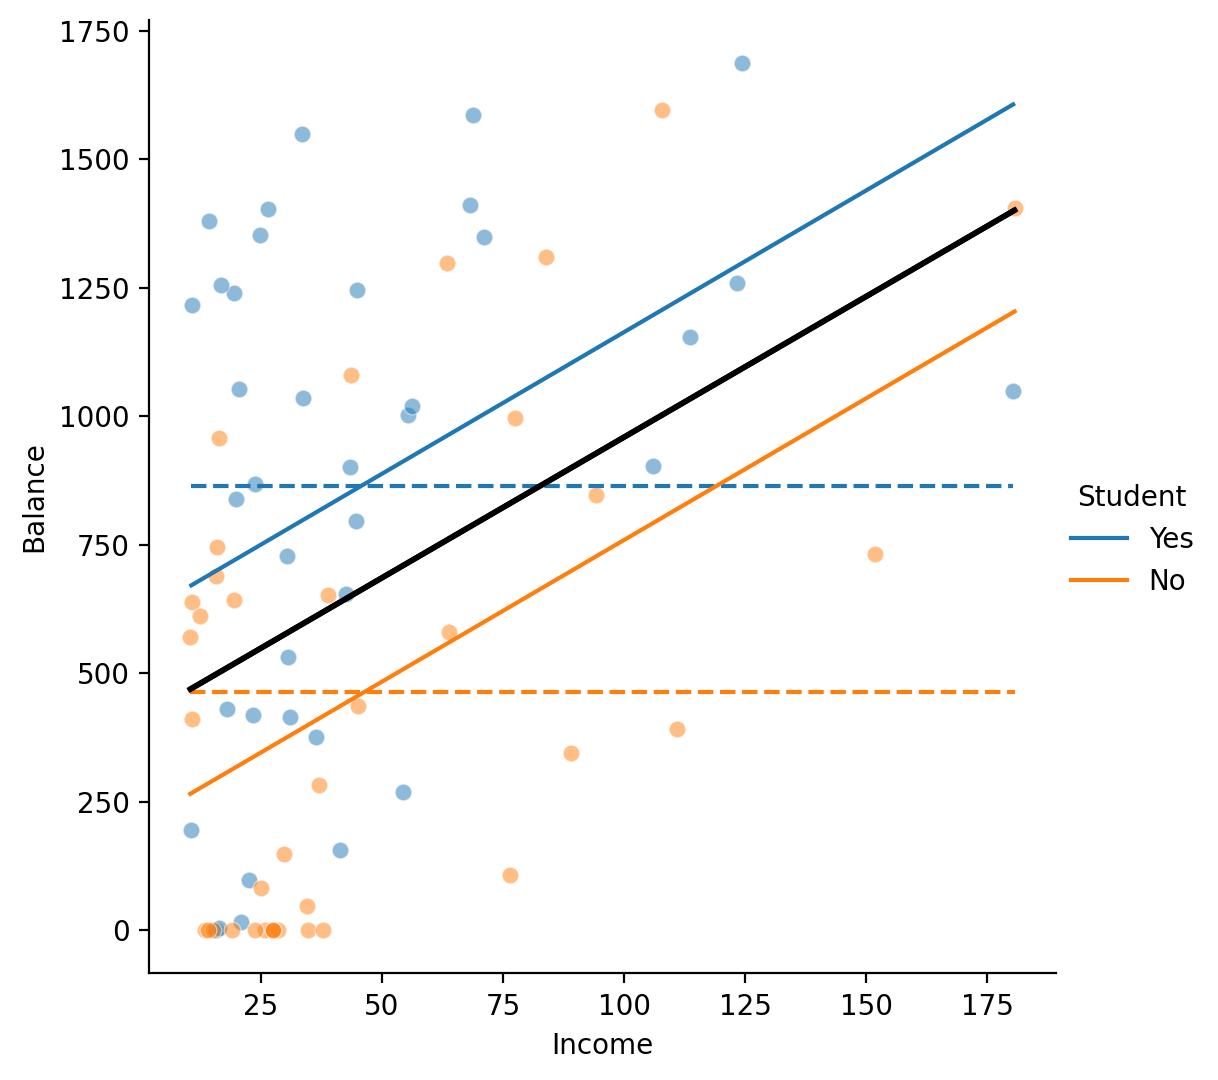

In [26]:
# Create grid
grid = sns.FacetGrid(data=df_models.to_pandas(), hue="Student", height=5.5, aspect=1);

# Plot data
grid.map(sns.scatterplot, "Income", "Balance",alpha=.5);

# Plot our predictions from student only model
grid.map(sns.lineplot, "Income", "balance_pred_s", ls='--');

# Plot our predictions from income only model
grid.map(sns.lineplot, "Income", "balance_pred_i", ls='-', color='black', lw=2);

# Plot our predictions student + income
grid.map(sns.lineplot, "Income", "balance_pred_si");

# Aesthetics
grid.set(ylabel='Balance');
grid.add_legend();

Let's take a look at the parameter estimates...


In [27]:
si_results.params

Intercept            207.855285
C(Student)[T.Yes]    404.633047
Income                 5.513813
dtype: float64



$\hat{\beta_0}$ is supposed to be the *mean* of `Student = No`...but its not

$\hat{\beta_1}$ is supposed to be the *mean difference* between `Student = Yes` and `Student = No`...but its not

$\hat{\beta_2}$ is supposed to be the *slope* of `Income`...but it doesn't match our univariate regression `i_results`


Our model with just `Student` shows that the $\hat{\beta}_0$ was the mean of `Student = No`

In [28]:
a_results.params

Intercept            463.236842
C(Student)[T.Yes]    401.447368
dtype: float64

And our model with just `Income` shows that the $\hat{\beta}_1$ was the slope of `Income`

In [29]:
i_results.params

Intercept    411.959178
Income         5.474981
dtype: float64

**What's going on?**


Remember what we learned in notebooks `02_models` and `03_models`:

In the GLM, we interpret each parameter estimate **assuming other parameter estimates = 0**

Because of this:

$\hat{\beta_0}$ is the *mean* of `Student = No` **when `Income = 0`**

$\hat{\beta_1}$ is the *mean difference* between `Student = Yes` and `Student = No` **when `Income = 0`**

$\hat{\beta_2}$ is the *slope* of `Income` **when `Student = 0 (No)`**




### Challenge

Can you make the parameter estimates **more interpretable** using an approach we learned in class and demonstrated in `02_models`? Think about how to change what value the regression "fixes" `Income` to from `0` to something more useful...

1. Fit a new more interpretable multiple regression called `si_interp_model` using `Student` and `Income` as predictors and save the results to `si_interp_results`
2. Compare your parameter estimates from `.summary()` or `.params` to the estimates from the original multiple regression. What do you notice?


In [30]:
# Solution
si_interp_model = ols('Balance ~ C(Student) + center(Income)', data=df.to_pandas())

si_interp_results = si_interp_model.fit()

print(si_interp_results.summary(slim=True))

                            OLS Regression Results                            
Dep. Variable:                Balance   R-squared:                       0.322
Model:                            OLS   Adj. R-squared:                  0.304
No. Observations:                  76   F-statistic:                     17.37
Covariance Type:            nonrobust   Prob (F-statistic):           6.75e-07
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           461.6440     70.383      6.559      0.000     321.371     601.917
C(Student)[T.Yes]   404.6330     99.538      4.065      0.000     206.254     603.012
center(Income)        5.5138      1.283      4.298      0.000       2.957       8.071

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.


### Visualizing intutions

Hopefully you remembered that you can *center* a predictor to change what the *fixed* value is when intepreting *other parameters*. It doesn't change the estimate for what you're centering (`Income`), but it always changes the intercept and other categorical parameters!

Let's visualize the effect of centering a predictor - we'll annotate the same plot as earlier illustrating the shift in coefficient interpretation:  

1. We'll add a vertical line for `Income = mean(Income)` and a horizontal line for the mean of `Student = No`- **this is our model intercept**
2. The vertical distance between this point and where it intersect the *blue* line is $\beta_1$ - **mean difference between Yes and No when Income is at its mean**

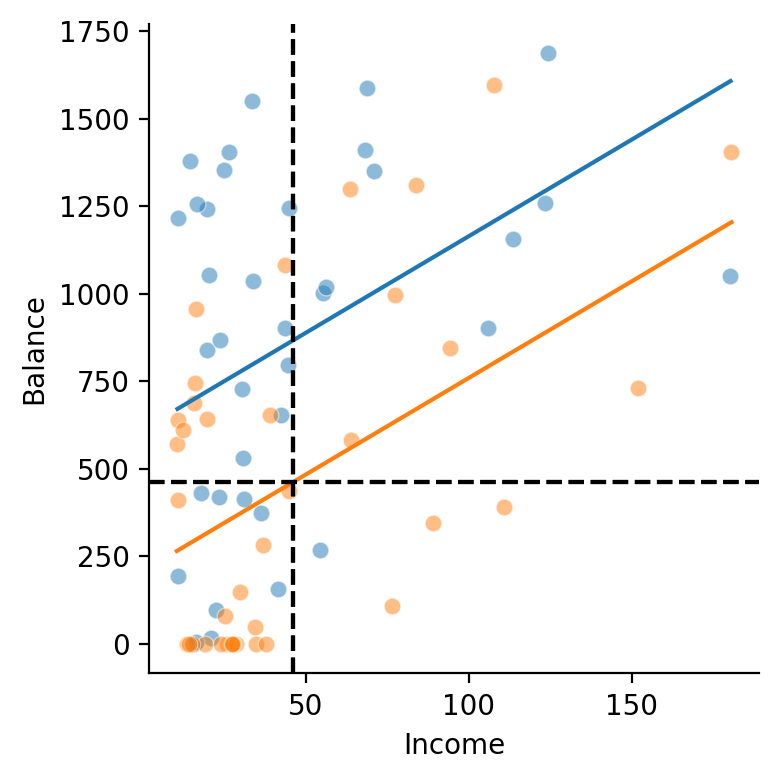

In [31]:
# Create grid
grid = sns.FacetGrid(data=df_models.to_pandas(), hue="Student", height=4)

# Plot data
grid.map(sns.scatterplot, "Income", "Balance",alpha=.5)

# Plot our predictions student + income
grid.map(sns.lineplot, "Income", "balance_pred_si")

# Plot Income mean
grid.map(plt.axvline, x=df_models['Income'].mean(), color="black", ls='--');

# Plot mean for Student = 0
grid.map(plt.axhline, y=student_no, color="black", ls='--');

# Aesthetics
grid.set(ylabel='Balance');


You'll also notice that **centering does not change model predictions**. It only changes how we *interpret* the parameter estimates from our model

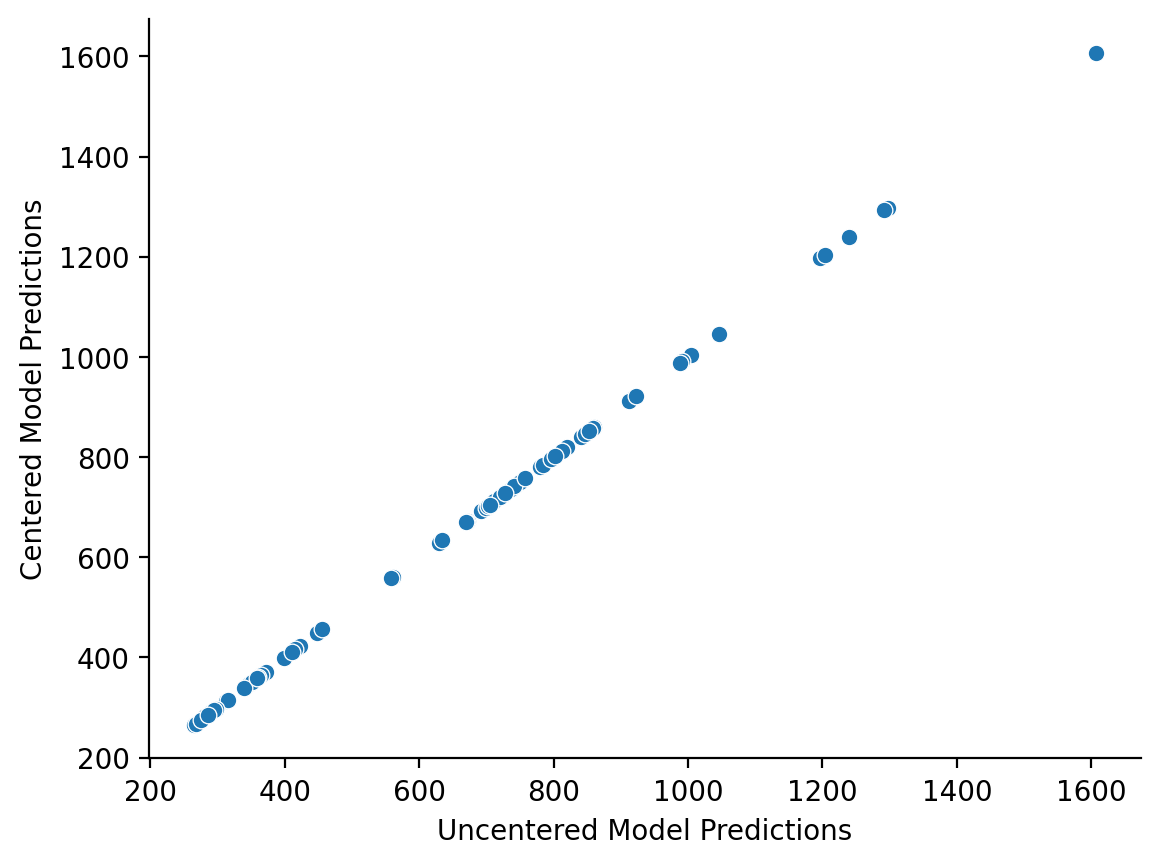

In [32]:
ax = sns.scatterplot(
    x=si_results.fittedvalues, # predictions fro un-centered model
    y=si_interp_results.fittedvalues, # predictions for centered model
)
ax.set(xlabel='Uncentered Model Predictions', ylabel='Centered Model Predictions');
sns.despine();

In notebook `03_models` we learned that we can use `.predict()` to generate predictions from our model by fixing one or more of our predictors at certain values.

Let's do that now to get our predicted estimates of the average `Balance` for each level of `Student` when `Income` is fixed at it's mean of 46.03 - **this is what our parameter estimate for `Student` is**

In [33]:
# Create 1-row dataframes to pass into .predict()
student_no_x =pl.DataFrame({
    'Income': df['Income'].mean(),
    'Student': 'No'
})

student_yes_x =pl.DataFrame({
    'Income': df['Income'].mean(),
    'Student': 'Yes'
})

In [34]:
# Generate predictions
student_no_prediction = si_interp_results.predict(student_no_x.to_pandas())

student_yes_prediction = si_interp_results.predict(student_yes_x.to_pandas())

In [35]:
print(f"Student (No): {student_no:.3f}")
print(f"Student (Yes): {student_yes:.3f}")

print(f"Student (No prediction): {student_no_prediction[0]:.3f}")
print(f"Student (Yes prediction): {student_yes_prediction[0]:.3f}")

print(f"Student (Yes prediction - No prediction): {student_yes_prediction[0] - student_no_prediction[0]:.3f}")

Student (No): 463.237
Student (Yes): 864.684
Student (No prediction): 461.644
Student (Yes prediction): 866.277
Student (Yes prediction - No prediction): 404.633


And we can verify that:

- $\beta_0$ = $\hat{balance}_{\text{student\_no}}$ when $Income = Income_{mean}$
- $\beta_1$ = $\hat{balance}_{\text{student\_yes}}$ - $\hat{balance}_{\text{student\_no}}$ when $Income = Income_{mean}$

In [36]:
si_interp_results.params

Intercept            461.644003
C(Student)[T.Yes]    404.633047
center(Income)         5.513813
dtype: float64

### Summary

When we **add** a categorical predictor to a model with a continuous predictor, we estimate different *intercepts* but the same *slope* for each level of the categorical variable. 

Intuitively, this is like accounting for differences in the means of each group when considering the continuous relationship between two predictors. 

Alternatively, we can think about it like accounting for the continuous relationship between another variable when considering the mean difference between groups.

**Centering** our continuous predictor makes our estimates more interpretable. It also makes sure we compare levels of our categorical predictor along a **meaningful value** of our continuous predictor!


## Interactions (2-levels and Continuous Predictor)

Our previous *multiple regression* tested whether students and non-students have a different `Balance` when accounting for the relationship between `Balance` and `Income`.

However, we did not test whether **the relationship between `Balance` and `Income` was different for students and non-students**

We can extend our previous model to test this by adding **an interaction term** to capture this relationship  
Specifically we add `Student` x `Income` to our model to **estimate separate slopes** for students and non-students


$$
\hat{Balance}_{i}= \beta_0 + \beta_1 Student + \beta_2 Income + \beta_3 Student \times Income
$$

### Challenge 

1. Estimate the model above and call it `six_model` and save the results to `six_results`.
2. Compare it to `si_results` from earlier using `anova_lm()`. Is the addition of the interaction term *worth it*?
3. Create 2 new columns in `df_models` called `balance_pred_six` and `resid_six` that include the `.fittedvalues` and `.resid` from this model

In [ ]:
# Your code here

In [37]:
# Solution
six_model = ols('Balance ~ C(Student) * Income', data=df.to_pandas())
six_results = six_model.fit()

anova_lm(si_results, six_results)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,73.0,1.374135e+07,0.0,NaN,NaN,NaN
1,72.0,1.368314e+07,1.0,58201.972255,0.306256,0.581701


In [38]:
# Solution
df_models = df_models.with_columns(
    balance_pred_six = six_results.fittedvalues.to_numpy(),
    resid_six = six_results.resid.to_numpy(),
)
df_models.head()

Balance,Student,Income,balance_pred_si,resid_si,balance_pred_i,resid_i,balance_pred_s,resid_s,balance_pred_six,resid_six
i64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64
16,"""Yes""",20.918,727.826282,-711.826282,526.484832,-510.484832,864.684211,-848.684211,746.752889,-730.752889
1216,"""Yes""",10.842,672.269098,543.730902,471.318923,744.681077,864.684211,351.315789,698.87892,517.12108
148,"""No""",29.705,371.643114,-223.643114,574.593491,-426.593491,463.236842,-315.236842,360.557752,-212.557752
108,"""No""",76.348,628.823915,-520.823915,829.963033,-721.963033,463.236842,-355.236842,648.864509,-540.864509
532,"""Yes""",30.622,781.332328,-249.332328,579.614049,-47.614049,864.684211,-332.684211,792.859379,-260.859379


### Interpreting Parameter Estimates

Let's use the `df_models` you updated to update our previous figure to see what's happening visually:

We've reduced the opacity of the previous models' predictions and overlayed the interaction model's predictions using **solid colored lines**.

As you can tell, now not only the *intercepts* are different for each level of `Student`, but the **slopes are also different**

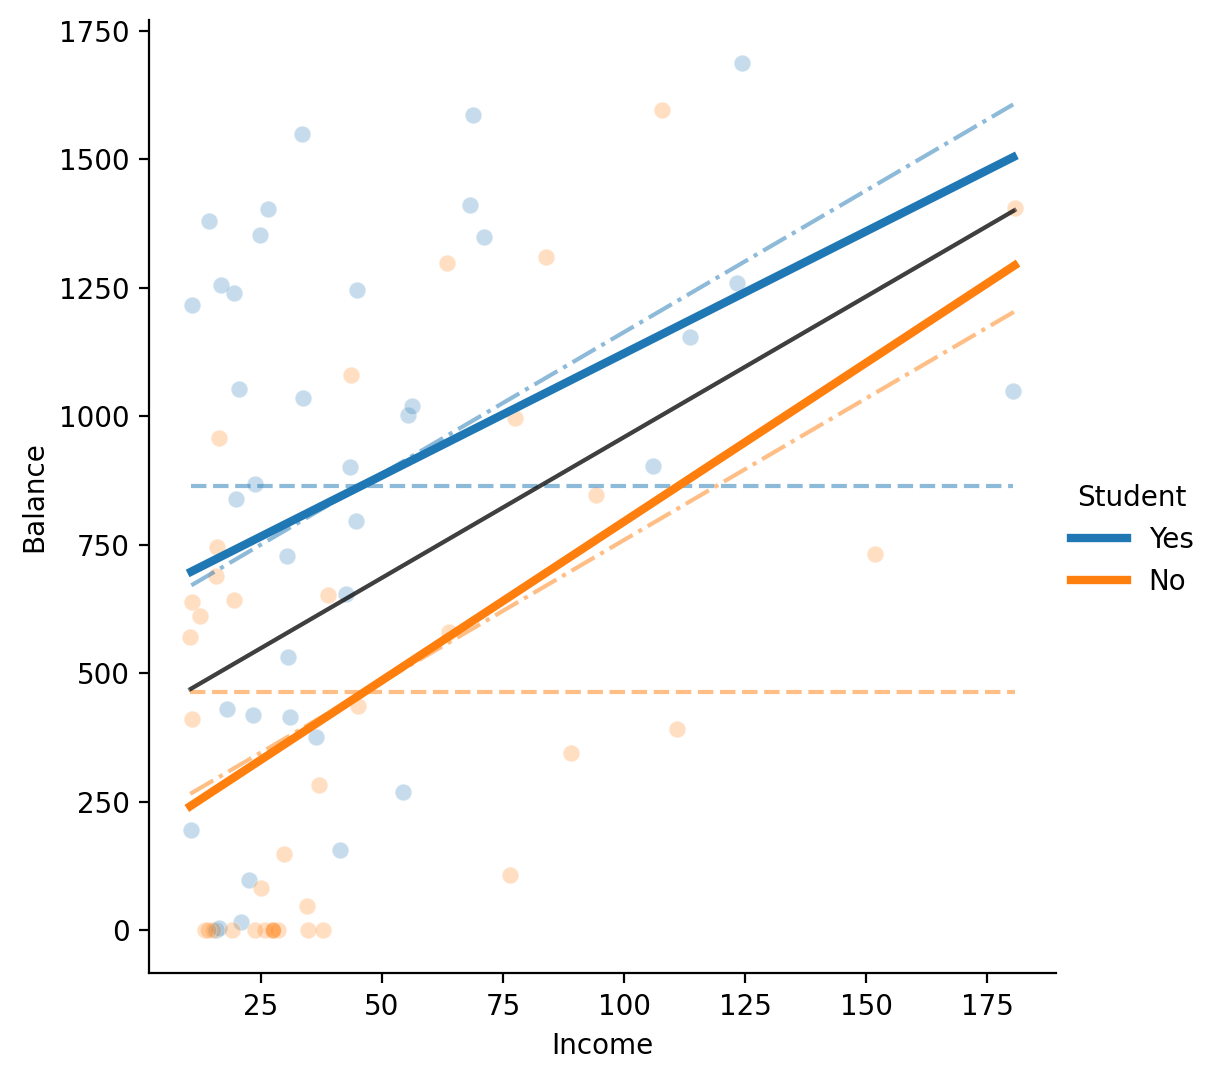

In [39]:
# Create grid
grid = sns.FacetGrid(data=df_models.to_pandas(), hue="Student", height=5.5, aspect=1);

# Plot data
grid.map(sns.scatterplot, "Income", "Balance",alpha=.25);

# Plot our predictions from student only model
grid.map(sns.lineplot, "Income", "balance_pred_s", ls='--', alpha=.5);

# Plot our predictions from income only model
grid.map(sns.lineplot, "Income", "balance_pred_i", ls='-', color='black', lw=1.5, alpha=0.5);

# Plot our predictions student + income
grid.map(sns.lineplot, "Income", "balance_pred_si", ls='-.', alpha=.5);

# Plot our predictions student x income
grid.map(sns.lineplot, "Income", "balance_pred_six", lw=3);

# Aesthetics
grid.set(ylabel='Balance');
grid.add_legend();

Let's inspect the parameter estimates

In [40]:
print(six_results.summary(slim=True))

                            OLS Regression Results                            
Dep. Variable:                Balance   R-squared:                       0.325
Model:                            OLS   Adj. R-squared:                  0.297
No. Observations:                  76   F-statistic:                     11.57
Covariance Type:            nonrobust   Prob (F-statistic):           2.82e-06
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                  176.9471    108.096      1.637      0.106     -38.539     392.434
C(Student)[T.Yes]          470.4184    155.351      3.028      0.003     160.732     780.105
Income                       6.1811      1.765      3.502      0.001       2.662       9.700
C(Student)[T.Yes]:Income    -1.4298      2.584     -0.553      0.582      -6.580       3.721

Notes:
[1] Standard Errors assume that the cov

Wait we forgot to **center**! Let's do that now to make these estimates more interpretable:

In [41]:
six_model_cent = ols('Balance ~ C(Student) * center(Income)', data=df.to_pandas())
six_results_cent = six_model_cent.fit()

print(six_results_cent.summary(slim=True))

                            OLS Regression Results                            
Dep. Variable:                Balance   R-squared:                       0.325
Model:                            OLS   Adj. R-squared:                  0.297
No. Observations:                  76   F-statistic:                     11.57
Covariance Type:            nonrobust   Prob (F-statistic):           2.82e-06
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                          461.4512     70.721      6.525      0.000     320.472     602.430
C(Student)[T.Yes]                  404.6055    100.014      4.045      0.000     205.231     603.980
center(Income)                       6.1811      1.765      3.502      0.001       2.662       9.700
C(Student)[T.Yes]:center(Income)    -1.4298      2.584     -0.553      0.582      -6.580       3.721

Let's verify that:

- $\beta_0$ = $\hat{balance}_{\text{student\_no}}$ when $Income = Income_{mean}$
- $\beta_1$ = $\hat{balance}_{\text{student\_yes}}$ - $\hat{balance}_{\text{student\_no}}$ when $Income = Income_{mean}$

just like we did before by generating a single **marginal prediction**

In [44]:
# Create 1-row dataframes to pass into .predict()
student_no_x =pl.DataFrame({
    'Income': df['Income'].mean(),
    'Student': 'No'
})

student_yes_x =pl.DataFrame({
    'Income': df['Income'].mean(),
    'Student': 'Yes'
})

# Generate predictions
student_no_prediction = six_results.predict(student_no_x.to_pandas())
student_yes_prediction = six_results.predict(student_yes_x.to_pandas())

print(f"Student (No): {student_no:.3f}")
print(f"Student (Yes): {student_yes:.3f}")

print(f"Student (No prediction): {student_no_prediction[0]:.3f}")
print(f"Student (Yes prediction): {student_yes_prediction[0]:.3f}")

print(f"Student (Yes prediction - No prediction): {student_yes_prediction[0] - student_no_prediction[0]:.3f}")

Student (No): 463.237
Student (Yes): 864.684
Student (No prediction): 461.451
Student (Yes prediction): 866.057
Student (Yes prediction - No prediction): 404.606


In [48]:
six_results_cent.params

Intercept                           461.451226
C(Student)[T.Yes]                   404.605544
center(Income)                        6.181137
C(Student)[T.Yes]:center(Income)     -1.429850
dtype: float64

To verify that:

- $\beta_2$ = $Balance \sim Income$ when $Student =0$
- $\beta_3$ = the difference between $Balance \sim Income$ when $Student =0$ vs $Student = 1$

we'll use the same approach we did in `03_models` - we'll set `Student = 0` and `Student = 1` and provide the original values for `Income` to generate **marginal predictions** for `Balance`. 

Then we'll estimate the slope of the relationship between these **marginal predictions** and our original values of `Income` using 2 *univariate* regressions:

In [54]:
# Get only student = yes or student = No
student_0_data = df.filter(col('Student') == 'No').select(['Income', 'Student']) 
student_1_data = df.filter(col('Student') == 'Yes').select(['Income', 'Student']) 

# Use values to get model predictions for Balance separately for students and non-students
student_0_predictions = six_results.predict(student_0_data.to_pandas())
student_1_predictions = six_results.predict(student_1_data.to_pandas())

In [58]:
# Create a new dataframe of Predicted_Balance ~ Income when Student = No
marginal_data_student_0 = pl.DataFrame({
    'Income': student_0_data['Income'].to_numpy(),
    'Predicted_Balance': student_0_predictions.to_numpy()
})

# Run univariate OLS to slope
marginal_student_0_params = ols('Predicted_Balance ~ Income', 
                                marginal_data_student_0.to_pandas()).fit().params

# Same for student = Yes
marginal_data_student_1 = pl.DataFrame({
    'Income': student_1_data['Income'].to_numpy(),
    'Predicted_Balance': student_1_predictions.to_numpy()
})

marginal_student_1_params = ols('Predicted_Balance ~ Income', 
                                marginal_data_student_1.to_pandas()).fit().params

print(f"Income slope for Student = No (0): {marginal_student_0_params['Income']:.4f}")
print(f"Income slope for Student = Yes (1): {marginal_student_1_params['Income']:.4f}")

print(f"Difference in slopes: {marginal_student_1_params['Income'] - marginal_student_0_params['Income']:.4f}")

Income slope for Student = No (0): 6.1811
Income slope for Student = Yes (1): 4.7513
Difference in slopes: -1.4298


And we can see the interaction term reflects this difference-in-slopes while `center(Income)` reflects the slope of `Student = No`

In [59]:
six_results_cent.params

Intercept                           461.451226
C(Student)[T.Yes]                   404.605544
center(Income)                        6.181137
C(Student)[T.Yes]:center(Income)     -1.429850
dtype: float64

### Summary

When we **multiply** a categorical predictor in a model with a continuous predictor, we estimate different *intercepts* and *different slopes* for each level of the categorical variable. 

Intuitively, this is like fitting a separate *univariate* regression to each level of the categorical variable and comparing the *difference-in-slopes* of both regressions.

Alternatively, we can think about it testing whether the *mean difference* between levels of our categorical variable *increase* or *decrease* as we move along the continuous predictor.

**Centering** our continuous predictor makes our estimates more interpretable. It also makes sure we compare levels of our categorical predictor along a **meaningful value** of our continuous predictor!


## Challenge

In the **Parameter Interpretation** section of `03_models` we had you answer a **response challenge** about a model you built using the advertising dataset:

$$
sales_i = \beta_0 + \beta_1 tv_i + \beta_2 radio_i
$$

<div align="center">
<img src="./figs/03_plot.png" width="60%" alt="Figure 1">
</div>

Specifically we said:

> Notice in the plot above that the slopes of the predicted lines **are not** changing - it looks like only the intercept is shifting up or down.  Can you provide an explanation why? What is our model failing to capture and how might we fix this? 

### Your tasks

Using what you learned about interactions in *multiple regression*:

1. Estimate the model using the formula above (same as in `03_models`)
2. Estimate a *new* model that captures what this model is missing
3. Compare this new model to the original model to see if it's *worth it*
4. Make a new figure like the one above that visualizes the predictions from your *new* model
5. Interpret the parameter estimates from `.summary()` and provide a natural-language explanation of what they mean
6. Fit another like you just did, but this time **center** each predictor
7. How are the parameter estimates from this model different to the uncentered one?
8. Compare the correlations between predictors in the centered and uncentered models using the provided function


| Variable   | Description                     |
|------------|---------------------------------|
| tv     | TV ad spending in $1000 of  dollars            |
| radio     | Radio ad spending in $1000 of  dollars            |
| newspaper     | Newspaper ad spending in $1000 of  dollars            |
| sales     | Sales generated in $1000 of  dollars            |

In [60]:
import numpy as np
import polars as pl
from polars import col
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
df = pl.read_csv('./data/advertising.csv')
df.head()

tv,radio,newspaper,sales
f64,f64,f64,f64
230.1,37.8,69.2,22.1
44.5,39.3,45.1,10.4
17.2,45.9,69.3,9.3
151.5,41.3,58.5,18.5
180.8,10.8,58.4,12.9


### 1) Estimate model from previous notebook

In [70]:
# Solution
model_c = ols('sales ~ tv + radio', data=df.to_pandas())
results_c = model_c.fit()

### 2) Estimate new model

In [71]:
# Solution
model_a = ols('sales ~ tv + radio + tv:radio', data=df.to_pandas())
results_a = model_a.fit()

### 3) Compare both models

In [69]:
# Solution
anova_lm(results_c, results_a)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,197.0,556.913980,0.0,NaN,NaN,NaN
1,196.0,174.483383,1.0,382.430597,429.590463,2.757681e-51


### 4) Figure of model predictions

In [ ]:
# Solution
# Save to variable just to make coding easier
tv = df['tv'].to_numpy()
zeros = np.repeat(0, len(tv))
twenty = np.repeat(20, len(tv))
forty = np.repeat(40, len(tv))

# We use all values in the TV column
# And just a bunch of 0s for radio
y_radio_0 = results_a.predict({'tv': tv, 'radio': zeros, 'tv:radio':tv * zeros})
y_radio_20 = results_a.predict({'tv': tv, 'radio': twenty, 'tv:radio':tv * twenty})
y_radio_40 = results_a.predict({'tv': tv, 'radio': forty, 'tv:radio':tv * forty})

grid = sns.relplot(
    data=df,
    kind='scatter',
    x='tv',
    y='sales',
    hue='radio',
    size='radio',

)
grid.set(xlabel='TV Spending ($1000)', ylabel='Sales ($1000)');
grid.legend.set_title('Radio Spending ($1000)');
grid.legend.set_bbox_to_anchor((.45, .8));

# Add them to the plot
grid.ax.plot(tv, y_radio_0, color='gray');
grid.ax.plot(tv, y_radio_20, color='gray');
grid.ax.plot(tv, y_radio_40, color='gray');

### 5) Interpret parameter estimates

In [ ]:
# Solution
print(results_a.summary())

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     1963.
Date:                Tue, 18 Feb 2025   Prob (F-statistic):          6.68e-146
Time:                        16:12:39   Log-Likelihood:                -270.14
No. Observations:                 200   AIC:                             548.3
Df Residuals:                     196   BIC:                             561.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.7502      0.248     27.233      0.0

### 6) Fit a model with centered predictors

In [74]:
# Solution
model_a_cent = ols('sales ~ center(tv) * center(radio)', data=df.to_pandas())
results_a_cent = model_a_cent.fit()

print(results_a_cent.summary(slim=True))

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.967
No. Observations:                 200   F-statistic:                     1963.
Covariance Type:            nonrobust   Prob (F-statistic):          6.68e-146
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   13.9470      0.067    208.737      0.000      13.815      14.079
center(tv)                   0.0444      0.001     56.673      0.000       0.043       0.046
center(radio)                0.1886      0.005     41.806      0.000       0.180       0.198
center(tv):center(radio)     0.0011   5.24e-05     20.727      0.000       0.001       0.001

Notes:
[1] Standard Errors assume that the cov

### 7) How are the parameter estimates from centered and un-centered models the same or different?

*Uncentered predictor slopes assume other predictors = 0*  
*Centered predictor slopes assume other predictors = their respective means*

### 8) Compare the correlations between centered and un-centered models

Use the provided function `plot_predictor_correlations` to visualize the correlation matrix of the predictors for both the centered and uncentered models.

Then answer the question below

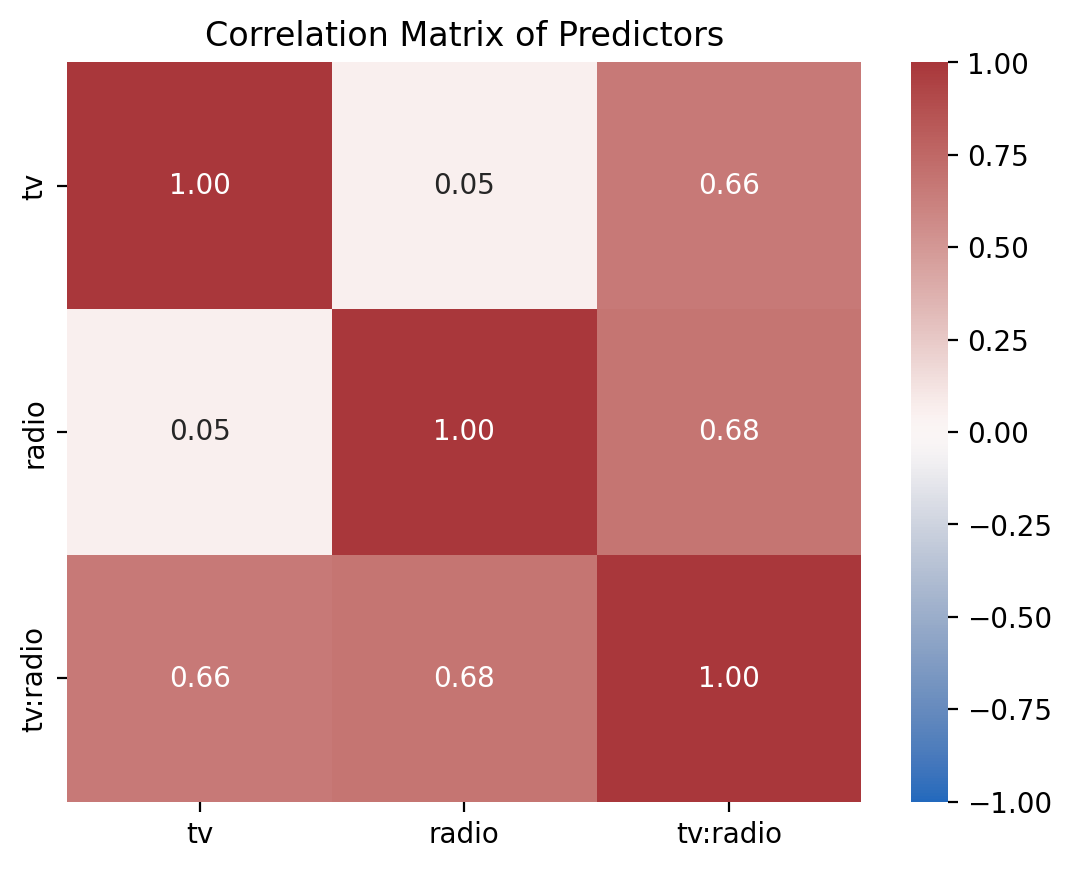

In [ ]:
from helpers import plot_predictor_correlations

# Example Usage
# plot_predictor_correlations(my_model)

# Solution
ax = plot_predictor_correlations(model_a)

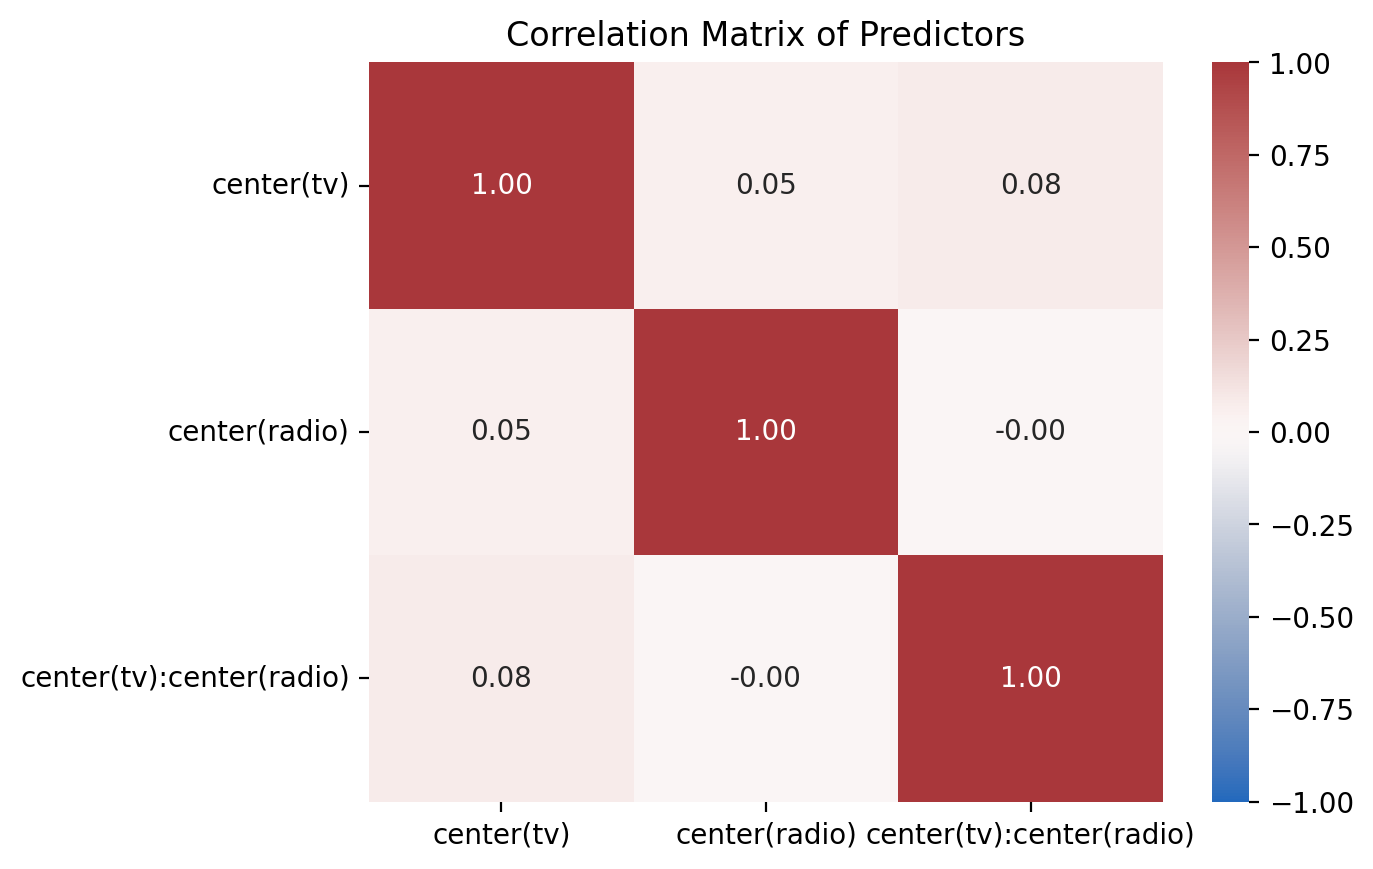

In [ ]:
# Solution
ax = plot_predictor_correlations(model_a_cent)

How do you think the change in correlation will affect our estimates and inferences?

*Your response here*